<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

<h1 align="center"><font size="5">Unsupervised Machine Learning - Final Assignment</font></h1>

## Importing required libraries

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, PCA, KernelPCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

## Importing the dataset

In [2]:
filepath = "Reviews.csv"
data = pd.read_csv(filepath, encoding='latin1')
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
#Creating a helpfulness fraction column
def fraction_conversion(numerator, denominator):
    return round((numerator/denominator), 2)
data['helpful_fraction'] = fraction_conversion(data['HelpfulnessNumerator'], data['HelpfulnessDenominator'])
#Only keeping reviews that are > 80% helpful
data = data.dropna(subset=['helpful_fraction'])
data = data[data['helpful_fraction'] >= 0.8]

#Drop any rows with na cols
data = data.dropna()

import re
#Processing the string-based columns so that they can be easily processed
def string_conversion(string):
    stopwords = ['a', 'and', 'the', 'or', 'but', 'because', 'then', 'in', 'is', 'it', 'to', 'for', 'my', 'of', 'too',
                 'very', 'you', 'your', 'an', 'are', 'as', 'at', 'all', 'was', 'way', 'what', 'with', 'be', 'from', 
                 'get', 'if', 'its', 'just', 'me', 'our', 'so', 'than', 'that', 'them', 'these', 'they', 'this', 'up']
    #Lowercase everything
    string = string.lower()
    #Remove any special characters
    string = re.sub(r'[^a-zA-Z\s]', "", string)
    #Removing all common words in the stopwords list
    pattern = r'\b(' + r'|'.join(stopwords) + r')\b'
    string = re.sub(pattern, '', string)
    return string
data['Summary'] = data['Summary'].apply(string_conversion)
data['Text'] = data['Text'].apply(string_conversion)

#Removing the unimportant features
data = data.drop(columns=['Id', 'ProductId', 'ProfileName', 'UserId', 'Time', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'helpful_fraction'])

#Keep only 10000 rows don't need so many
data = data.iloc[0:10000, :]

,Score,Summary,Text
0,5,good quality dog food,i have bought several vitality canned dog fo...
2,4,delight says,confection has been around few centuries ...
3,2,cough medicine,looking secret ingredient robitussin i b...
8,5,yay barley,right now im mostly sprouting cats can eat...
10,5,best hot sauce world,i dont know cactus tequila unique comb...
...,...,...,...
29185,4,great taste,we ordered popcorn machine fundraiser use ...
29186,5,great popcorn,best tasting popcorn i have ever tried i ...
29187,5,perfect popcorn,great popcorn does have salt incuded do...
29188,5,better movie popcorn,santa delivered fancy popcorn popper house ...


In [9]:
data[data['Score'] < 2]

,Score,Summary,Text
12,1,cats not fans new food,cats have been happily eating felidae platinu...
62,1,stale product,arrived days were stale i could not eat an...
153,1,rip off price,singles sell store box singles im n...
167,1,low quality,i dont know how long sat on back shelf som...
168,1,not banana runts,besides being smaller runts look same have...
...,...,...,...
29075,1,contains msg,i agree earlier review generally i would say ...
29077,1,ummmno,product arrived i happy love izzes however ...
29086,1,bogus reviews,snack shop could not fulfill order provided...
29116,1,not much nuts price,i purchased two orders gifts looks attrac...


In [66]:
#Creating the array of summaries
summaries = list(data['Summary'])

#Creating the tf-idf matrix
cv = CountVectorizer(min_df=0.005)
tf_mat = cv.fit_transform(summaries)
tf = pd.DataFrame(tf_mat.toarray(), columns=cv.get_feature_names_out())
tdif_trans = TfidfTransformer()
tfidf_mat = tdif_trans.fit_transform(tf)
tfidf = pd.DataFrame(tfidf_mat.toarray(), columns=tdif_trans.get_feature_names_out())
tfidf

,alternative,amazing,awesome,baby,bad,best,better,buy,can,cat,...,tea,toy,treat,treats,value,will,wonderful,works,yum,yummy
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.554384,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[Text(0.5, 0, 'n_components'), Text(0, 0.5, 'error')]

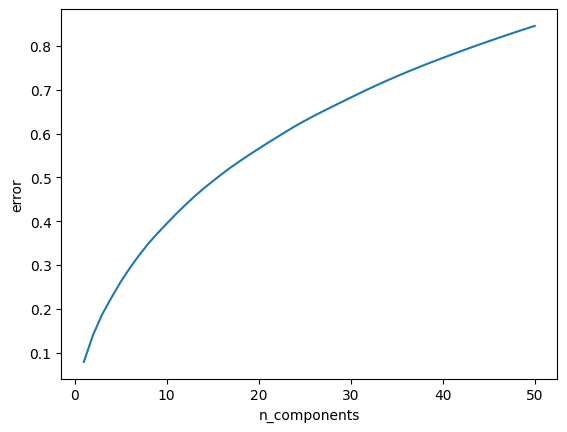

In [67]:
#Performing NMF on the tf-idf DataFrame and determining a best k
pca = PCA(n_components=50)
x_trans = pca.fit_transform(tfidf_mat)
explained_variance = pca.explained_variance_ratio_.cumsum()

fig, ax = plt.subplots()
ax.plot(range(1, len(explained_variance)+1), explained_variance)
ax.set(xlabel='n_components', ylabel='error')
#Seems like around 20 is the elbow point

In [68]:
#Build and get optimized PCA and transform the original data
optimized_pca = NMF(n_components=20)
new_x = optimized_pca.fit_transform(tfidf_mat)
new_df = pd.DataFrame(new_x, columns=optimized_pca.get_feature_names_out())
new_df

,nmf0,nmf1,nmf2,nmf3,nmf4,nmf5,nmf6,nmf7,nmf8,nmf9,nmf10,nmf11,nmf12,nmf13,nmf14,nmf15,nmf16,nmf17,nmf18,nmf19
0,0.000000,0.076250,0.000000,0.000000,0.000000,0.000253,0.000000,0.00233,0.001251,0.185160,0.005976,0.000551,0.000000,0.000000,0.000000,0.000000,0.000000,0.000417,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000426,0.000249,0.122637,0.000754,0.001942,0.000000,0.000180,0.00000,0.000000,0.000000,0.000934,0.000436,0.002238,0.000000,0.003865,0.005661,0.000234,0.000000,0.004622,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.100414,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.219733,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9996,0.183236,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9997,0.000265,0.000000,0.000000,0.000000,0.001739,0.000063,0.002837,0.00000,0.005382,0.004798,0.000000,0.000000,0.000000,0.002707,0.000000,0.005131,0.002679,0.000991,0.000000,0.000000
9998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.287619


In [ ]:
#KMeans model
kmeans = KMeans(n_clusters=2, init='k-means++')
predictions = kmeans.fit_predict(new_df)

#Confusion matrix display
#Classifying a score of under 3 as bad
truth = [0 if score <= 3 else 1 for score in data['Score']]
conf = confusion_matrix(truth, predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=[0,1])
cm_display.plot()
plt.show()

# 1. About the Data

## Dataset Summary


## Objective of the Analysis


## Data Cleaning and Feature Engineering

# 2. Model Construction & Testing

## Scaling Features

## Summary of the models

## Final Prediction:


## Summary Key Findings

## Next Steps